In [46]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import requests
import os
import shutil
import folium
import shapely
import matplotlib
from ipywidgets import interact
import seaborn as sns
import math
import stats
import scipy
import sklearn 

# basic cleaning and adjustments

In [192]:
geo = gpd.read_file('wdl_data/m_risk_prfile.geojson')
df = pd.DataFrame(geo).drop(columns='Link_ID')
df_ren = df.rename(columns={
                    'Daily_Aver':'Daily_Average_Traffic_Intensity',
                    'Average_Ve':'Average_Velocity_of_Vehicle_Traffic',
                    'Median_of_':'Median_of_velocity_of_Vehicle_Traffic',
                    'First_Quar': 'FirstQuartil_of_velocity_of_Vehicle_Traffic',
                    'Third_Quar': 'ThirdQuartil_of_velocity_of_Vehicle_Traffic'
                })


In [193]:
# remove outliers
def rm_out(df):
    for i in df.columns.drop(['linkid', 'Daily_Average_Traffic_Intensity','geometry']):
        lb = 0
        ub = 180
#         print(lb, ub)
        df[i] = df[i].mask(df[i] < lb) 
        df[i] = df[i].mask(df[i] > ub) 
    return df

data = rm_out(df_ren)

In [195]:
data = data.drop(columns='geometry')

In [197]:
data.columns

Index(['linkid', 'Daily_Average_Traffic_Intensity',
       'Average_Velocity_of_Vehicle_Traffic',
       'Median_of_velocity_of_Vehicle_Traffic',
       'FirstQuartil_of_velocity_of_Vehicle_Traffic',
       'ThirdQuartil_of_velocity_of_Vehicle_Traffic', 'Func_Class',
       'Speed_Cat'],
      dtype='object')

# cleaning for pipeline 

- feature creation

In [198]:
max_speed_dict = {2:130,3:100,4:90,5:70,6:50,7:30}
data['Max_speed'] = data['Speed_Cat'].map(max_speed_dict)
data['Speed_Diff_Mean'] = data['Max_speed'] - data['Average_Velocity_of_Vehicle_Traffic']
data['Speed_Diff_Median'] = data['Max_speed'] - data['Median_of_velocity_of_Vehicle_Traffic']

- duplicates

In [199]:
len(data) == len(data.drop_duplicates())

True

no need 

- missing values

In [200]:
data.isnull().sum().sort_values(ascending=False)

Average_Velocity_of_Vehicle_Traffic            45
Speed_Diff_Mean                                45
ThirdQuartil_of_velocity_of_Vehicle_Traffic     4
Median_of_velocity_of_Vehicle_Traffic           3
Speed_Diff_Median                               3
FirstQuartil_of_velocity_of_Vehicle_Traffic     1
linkid                                          0
Daily_Average_Traffic_Intensity                 0
Func_Class                                      0
Speed_Cat                                       0
Max_speed                                       0
dtype: int64

- the linkid of street that are nan in average are the same in speed
- we have just 45 nan values on a total of 4000 rows 
- we will substitute with the average of the entire column

In [201]:
mean_avg = data.Average_Velocity_of_Vehicle_Traffic.mean()
mean_speed = data.Speed_Diff_Mean.mean()

In [202]:
data['Average_Velocity_of_Vehicle_Traffic'] = data['Average_Velocity_of_Vehicle_Traffic'].replace(np.nan, mean_avg)

In [203]:
data['Speed_Diff_Mean'] = data['Speed_Diff_Mean'].replace(np.nan, mean_speed)

- for all the rest i can just drop the rows

In [204]:
data.dropna(inplace=True)

## first pipeline for scaling

In [205]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [206]:
data.columns

Index(['linkid', 'Daily_Average_Traffic_Intensity',
       'Average_Velocity_of_Vehicle_Traffic',
       'Median_of_velocity_of_Vehicle_Traffic',
       'FirstQuartil_of_velocity_of_Vehicle_Traffic',
       'ThirdQuartil_of_velocity_of_Vehicle_Traffic', 'Func_Class',
       'Speed_Cat', 'Max_speed', 'Speed_Diff_Mean', 'Speed_Diff_Median'],
      dtype='object')

In [207]:
numerical = ['Daily_Average_Traffic_Intensity',
       'Average_Velocity_of_Vehicle_Traffic',
       'Median_of_velocity_of_Vehicle_Traffic',
       'FirstQuartil_of_velocity_of_Vehicle_Traffic',
       'ThirdQuartil_of_velocity_of_Vehicle_Traffic',
        'Max_speed', 'Speed_Diff_Mean',
       'Speed_Diff_Median' ]
categorical = ['Func_Class',
       'Speed_Cat']

In [208]:
# num_transformer = StandardScaler()
# cat_transformer = OneHotEncoder(handle_unknown='ignore')
# preprocessor = ColumnTransformer([
#     ('num_transformer', num_transformer, numerical),

# df_scaled = pd.DataFrame(preprocessor.fit_transform(data))

In [209]:
scaler = StandardScaler()
data_scaled = data.copy()
for column in numerical:
    scaler.fit(data_scaled[[column]])
    data_scaled[column]=scaler.transform(data_scaled[[column]]) 
data_scaled

,linkid,Daily_Average_Traffic_Intensity,Average_Velocity_of_Vehicle_Traffic,Median_of_velocity_of_Vehicle_Traffic,FirstQuartil_of_velocity_of_Vehicle_Traffic,ThirdQuartil_of_velocity_of_Vehicle_Traffic,Func_Class,Speed_Cat,Max_speed,Speed_Diff_Mean,Speed_Diff_Median
0,80216819,1.058039,-0.448154,-0.476554,-0.650809,-0.335520,2,6,-0.716756,-0.549998,-0.506457
1,80216858,-0.405185,0.964251,1.051571,1.147324,0.946946,2,4,0.624480,-0.253245,-0.414450
2,80216859,-0.440889,0.404782,0.436235,0.705497,0.263588,3,6,-0.716756,-1.640539,-1.733852
3,80216860,-0.417922,-0.352559,-0.495085,-0.696019,0.226144,3,6,-0.716756,-0.672223,-0.481538
4,80216867,-0.454138,-0.194630,-0.125883,0.061594,-0.335520,3,6,-0.716756,-0.874147,-0.977991
...,...,...,...,...,...,...,...,...,...,...,...
34673,1223266734,-0.380995,-0.481696,-0.515042,-0.280907,-0.672518,3,4,0.624480,1.595506,1.692121
34674,1223277122,-0.618153,2.086023,2.119263,1.815202,2.098358,2,3,0.959789,-1.161858,-1.313433
34675,1223277123,-0.614448,2.168871,2.308853,1.897402,2.117080,2,3,0.959789,-1.267785,-1.568368
34676,1223277124,-0.278775,2.000749,2.074360,2.070023,2.023469,2,3,0.959789,-1.052828,-1.253053


In [210]:
data.Func_Class.value_counts()

3    25023
2     8363
1     1287
Name: Func_Class, dtype: int64

In [211]:
ohe = OneHotEncoder(sparse = False)
ohe.fit(data_scaled[['Func_Class']])
func_encoded = ohe.transform(data_scaled[['Func_Class']])

In [212]:
data_scaled["func_1"],data_scaled["func_2"],data_scaled['func_3'] = func_encoded.T

In [213]:
data_scaled.Speed_Cat.unique()

array([6, 4, 2, 5, 7, 3])

In [214]:
ohe = OneHotEncoder(sparse = False)
ohe.fit(data_scaled[['Speed_Cat']])
speed_encoded = ohe.transform(data_scaled[['Speed_Cat']])
data_scaled["speed_2"],data_scaled["speed_3"],data_scaled["speed_4"],data_scaled["speed_5"], data_scaled["speed_6"], data_scaled["speed_7"]= speed_encoded.T

In [215]:
data_scaled

,linkid,Daily_Average_Traffic_Intensity,Average_Velocity_of_Vehicle_Traffic,Median_of_velocity_of_Vehicle_Traffic,FirstQuartil_of_velocity_of_Vehicle_Traffic,ThirdQuartil_of_velocity_of_Vehicle_Traffic,Func_Class,Speed_Cat,Max_speed,Speed_Diff_Mean,Speed_Diff_Median,func_1,func_2,func_3,speed_2,speed_3,speed_4,speed_5,speed_6,speed_7
0,80216819,1.058039,-0.448154,-0.476554,-0.650809,-0.335520,2,6,-0.716756,-0.549998,-0.506457,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,80216858,-0.405185,0.964251,1.051571,1.147324,0.946946,2,4,0.624480,-0.253245,-0.414450,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,80216859,-0.440889,0.404782,0.436235,0.705497,0.263588,3,6,-0.716756,-1.640539,-1.733852,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,80216860,-0.417922,-0.352559,-0.495085,-0.696019,0.226144,3,6,-0.716756,-0.672223,-0.481538,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,80216867,-0.454138,-0.194630,-0.125883,0.061594,-0.335520,3,6,-0.716756,-0.874147,-0.977991,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34673,1223266734,-0.380995,-0.481696,-0.515042,-0.280907,-0.672518,3,4,0.624480,1.595506,1.692121,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
34674,1223277122,-0.618153,2.086023,2.119263,1.815202,2.098358,2,3,0.959789,-1.161858,-1.313433,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
34675,1223277123,-0.614448,2.168871,2.308853,1.897402,2.117080,2,3,0.959789,-1.267785,-1.568368,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
34676,1223277124,-0.278775,2.000749,2.074360,2.070023,2.023469,2,3,0.959789,-1.052828,-1.253053,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# exporting cleaned and ready df 

In [216]:
df.head()

,linkid,Daily_Aver,Average_Ve,Median_of_,First_Quar,Third_Quar,Func_Class,Speed_Cat,geometry
0,80216819,6224.778569,45.208716,44.464286,28.000000,59.00,2,6,"MULTILINESTRING ((-9.16402 38.77030, -9.16389 ..."
1,80216858,2236.054168,79.563308,82.750000,71.750000,93.25,2,4,"MULTILINESTRING ((-9.16645 38.74274, -9.16638 ..."
2,80216859,2138.725039,65.955069,67.333333,61.000000,75.00,3,6,"MULTILINESTRING ((-9.16645 38.74274, -9.16637 ..."
3,80216860,2201.335041,47.533911,44.000000,26.900000,74.00,3,6,"MULTILINESTRING ((-9.16588 38.74370, -9.16568 ..."
4,80216867,2102.610278,51.375291,53.250000,45.333333,59.00,3,6,"MULTILINESTRING ((-9.16472 38.74478, -9.16487 ..."


In [227]:
data_scaled_merged = data_scaled.merge(df_ren[['linkid','geometry']], on= 'linkid',how='left')

In [228]:
data_scaled

,linkid,Daily_Average_Traffic_Intensity,Average_Velocity_of_Vehicle_Traffic,Median_of_velocity_of_Vehicle_Traffic,FirstQuartil_of_velocity_of_Vehicle_Traffic,ThirdQuartil_of_velocity_of_Vehicle_Traffic,Func_Class,Speed_Cat,Max_speed,Speed_Diff_Mean,Speed_Diff_Median,func_1,func_2,func_3,speed_2,speed_3,speed_4,speed_5,speed_6,speed_7
0,80216819,1.058039,-0.448154,-0.476554,-0.650809,-0.335520,2,6,-0.716756,-0.549998,-0.506457,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,80216858,-0.405185,0.964251,1.051571,1.147324,0.946946,2,4,0.624480,-0.253245,-0.414450,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,80216859,-0.440889,0.404782,0.436235,0.705497,0.263588,3,6,-0.716756,-1.640539,-1.733852,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,80216860,-0.417922,-0.352559,-0.495085,-0.696019,0.226144,3,6,-0.716756,-0.672223,-0.481538,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,80216867,-0.454138,-0.194630,-0.125883,0.061594,-0.335520,3,6,-0.716756,-0.874147,-0.977991,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34673,1223266734,-0.380995,-0.481696,-0.515042,-0.280907,-0.672518,3,4,0.624480,1.595506,1.692121,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
34674,1223277122,-0.618153,2.086023,2.119263,1.815202,2.098358,2,3,0.959789,-1.161858,-1.313433,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
34675,1223277123,-0.614448,2.168871,2.308853,1.897402,2.117080,2,3,0.959789,-1.267785,-1.568368,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
34676,1223277124,-0.278775,2.000749,2.074360,2.070023,2.023469,2,3,0.959789,-1.052828,-1.253053,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [229]:
data_scaled_merged

,linkid,Daily_Average_Traffic_Intensity,Average_Velocity_of_Vehicle_Traffic,Median_of_velocity_of_Vehicle_Traffic,FirstQuartil_of_velocity_of_Vehicle_Traffic,ThirdQuartil_of_velocity_of_Vehicle_Traffic,Func_Class,Speed_Cat,Max_speed,Speed_Diff_Mean,...,func_1,func_2,func_3,speed_2,speed_3,speed_4,speed_5,speed_6,speed_7,geometry
0,80216819,1.058039,-0.448154,-0.476554,-0.650809,-0.335520,2,6,-0.716756,-0.549998,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"MULTILINESTRING ((-9.16402 38.77030, -9.16389 ..."
1,80216858,-0.405185,0.964251,1.051571,1.147324,0.946946,2,4,0.624480,-0.253245,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,"MULTILINESTRING ((-9.16645 38.74274, -9.16638 ..."
2,80216859,-0.440889,0.404782,0.436235,0.705497,0.263588,3,6,-0.716756,-1.640539,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,"MULTILINESTRING ((-9.16645 38.74274, -9.16637 ..."
3,80216860,-0.417922,-0.352559,-0.495085,-0.696019,0.226144,3,6,-0.716756,-0.672223,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,"MULTILINESTRING ((-9.16588 38.74370, -9.16568 ..."
4,80216867,-0.454138,-0.194630,-0.125883,0.061594,-0.335520,3,6,-0.716756,-0.874147,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,"MULTILINESTRING ((-9.16472 38.74478, -9.16487 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34668,1223266734,-0.380995,-0.481696,-0.515042,-0.280907,-0.672518,3,4,0.624480,1.595506,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,"MULTILINESTRING ((-8.53497 41.27065, -8.53505 ..."
34669,1223277122,-0.618153,2.086023,2.119263,1.815202,2.098358,2,3,0.959789,-1.161858,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"MULTILINESTRING ((-8.46988 41.23316, -8.47069 ..."
34670,1223277123,-0.614448,2.168871,2.308853,1.897402,2.117080,2,3,0.959789,-1.267785,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"MULTILINESTRING ((-8.47069 41.23324, -8.47099 ..."
34671,1223277124,-0.278775,2.000749,2.074360,2.070023,2.023469,2,3,0.959789,-1.052828,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"MULTILINESTRING ((-8.47747 41.23388, -8.47775 ..."


In [230]:
data_scaled_merged.to_csv('wdl_data/preprocessed_data')

# Base model kmeans

In [234]:
df_cleaned = pd.read_csv('wdl_data/preprocessed_data')
df_cleaned_no = df_cleaned.drop(columns='geometry')

In [244]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(df_cleaned_no)
Xp = pca.transform(df_cleaned_no)
# pd.DataFrame(Xp)
df_Xp = pd.DataFrame(Xp)
df_Xp.std()**2 / ((df_Xp.std()**2).sum())

0     1.000000e+00
1     1.222639e-09
2     1.275263e-16
3     4.711257e-17
4     1.697911e-17
5     5.711125e-18
6     3.151331e-18
7     1.826896e-18
8     1.611854e-18
9     1.309351e-18
10    1.094863e-18
11    9.969219e-19
12    3.592990e-19
13    3.177040e-19
14    2.484776e-20
15    9.896498e-47
16    3.116062e-47
17    9.836111e-48
18    3.136167e-48
19    2.169428e-48
20    1.043353e-48
dtype: float64

Text(0.5, 0, 'k cluster number')

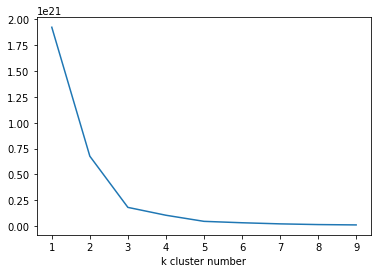

In [245]:
from sklearn.cluster import KMeans
ks = range(1,10)
inertias = []
for k in ks:
    km_test = KMeans(n_clusters=k).fit(Xp)
    inertias.append(km_test.inertia_)
plt.plot(ks, inertias)
plt.xlabel('k cluster number')

In [246]:
km = KMeans(n_clusters=5)
km.fit(Xp)

KMeans(n_clusters=5)

In [247]:
km.cluster_centers_

array([[ 3.32515198e+08,  1.18161222e+03, -5.63481044e-01,
        -6.21813541e-02, -1.88740286e-02,  5.61868663e-02,
        -9.13205566e-03,  1.11116642e-02, -2.02432922e-03,
        -3.80050455e-03, -1.75288065e-02,  7.13312542e-04,
         4.77027877e-05,  1.02292908e-04,  1.39962314e-04,
         4.23121045e-16, -3.56516206e-16, -1.29719940e-16,
         1.54464938e-16,  2.56883147e-16, -6.51961235e-18],
       [-2.20271480e+07,  4.66979572e+02,  8.40043488e-02,
         8.22043042e-02, -1.14232240e-01,  8.68787555e-02,
         1.30387795e-02, -2.54615457e-02, -1.42337515e-02,
        -1.36301598e-03,  7.63619144e-03,  3.12938660e-03,
         3.90955816e-03, -4.56612602e-05, -3.02431330e-04,
        -1.91432000e-16,  1.03169067e-16,  7.67230337e-17,
         5.24198347e-17,  4.83426679e-17,  6.18004294e-17],
       [-2.96039731e+08,  3.01013816e+02, -1.62356572e-01,
        -7.31824905e-02,  4.80327849e-02, -3.04970594e-02,
        -4.94347436e-03,  1.94251515e-02,  5.73202540e

Text(0, 0.5, 'PC 2')

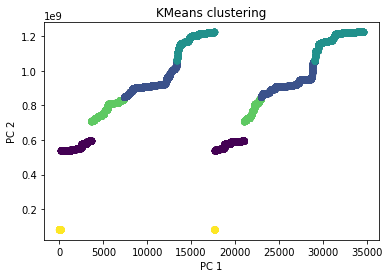

In [248]:
plt.scatter(df_cleaned_no.iloc[:,0], df_cleaned_no.iloc[:,1], c=km.labels_)
plt.title('KMeans clustering'); plt.xlabel('PC 1'); plt.ylabel('PC 2')


- **speed diff mean is the new y**
- **not using the unsupervised for now**